Расмотрим пример на датасете из репозитория UCI

Описание данных - https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

In [7]:
import pandas as pd
import numpy as np
data = pd.read_csv("crx.data", header=None)
data.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.50,u,g,q,h,1.50,t,f,0,f,g,00280,824,+


У нас есть 4 признака и 1 целевая переменная (бинарная) - нужно определить поддельная купюра или нет

In [8]:
print(data.shape)

(690, 16)


Всего 1372 купюры

Посмотрим на соотношение классов

In [9]:
data.iloc[:, -1].value_counts()

-    383
+    307
Name: 15, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   8       690 non-null    object 
 9   9       690 non-null    object 
 10  10      690 non-null    int64  
 11  11      690 non-null    object 
 12  12      690 non-null    object 
 13  13      690 non-null    object 
 14  14      690 non-null    int64  
 15  15      690 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 86.4+ KB


Разбиваем выборку на тренировочную и тестовую части и обучаем модель (в примере - градиентный бустинг)

In [11]:
data.describe(include='object')

,0,1,3,4,5,6,8,9,11,12,13,15
count,690,690,690,690,690,690,690,690,690,690,690,690
unique,3,350,4,4,15,10,2,2,2,3,171,2
top,b,?,u,g,c,v,t,f,f,g,00000,-
freq,468,12,519,519,137,399,361,395,374,625,132,383


In [12]:
t = [0,1,3,4,5,6,8,9,11,12,13,15]
for tt in t:
    k = 0
    for i in data[tt].unique():
        data.loc[data[tt] == i, tt] = k
        k = k + 1
    data[tt]=  pd.to_numeric(data[tt], errors='coerce')

In [13]:
NUM_FEATURE_NAMES = [2,7,10,14]

CAT_FEATURE_NAMES = [0,1,3,4,5,6,8,9,11,12,13,15]

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES 

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

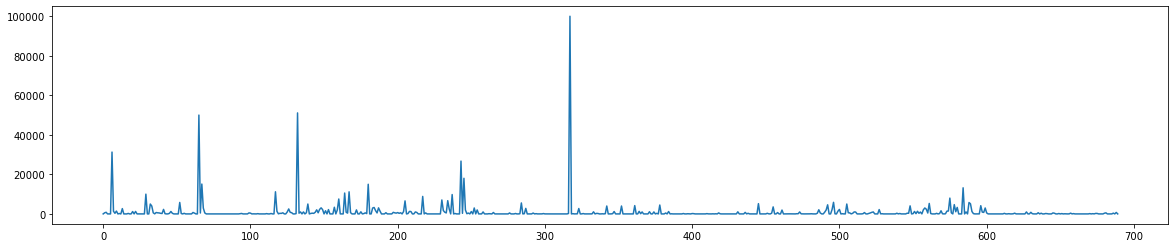

In [20]:
plt.figure(figsize =(20,4))
plt.plot(data[14])
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [23]:
data_norm = data.copy()
data_norm[NUM_FEATURE_NAMES] = np.log10(data_norm[NUM_FEATURE_NAMES] + 1)
data = data_norm.copy()

In [24]:
from sklearn.model_selection import train_test_split

x_data = data.iloc[:,:-1]
y_data = data.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=7)

In [25]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(x_train, y_train)
y_predict = model.predict(x_test)

[20:30:04] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Проверяем качество

In [26]:
from sklearn.metrics import recall_score, precision_score, roc_auc_score, accuracy_score, f1_score

def evaluate_results(y_test, y_predict):
    print('Classification results:')
    f1 = f1_score(y_test, y_predict)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary')
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 

    
evaluate_results(y_test, y_predict)

Classification results:
f1: 91.36%
roc: 89.54%
recall: 91.36%
precision: 91.36%


### Теперь очередь за PU learning

Представим, что нам неизвестны негативы и часть позитивов

In [48]:
mod_data = data.copy()
#get the indices of the positives samples
pos_ind = np.where(mod_data.iloc[:,-1].values == 1)[0]
#shuffle them
np.random.shuffle(pos_ind)
# leave just 20% of the positives marked
pos_sample_len = int(np.ceil(0.6 * len(pos_ind)))
print(f'Using {pos_sample_len}/{len(pos_ind)} as positives and unlabeling the rest')
pos_sample = pos_ind[:pos_sample_len]

Using 230/383 as positives and unlabeling the rest


Создаем столбец для новой целевой переменной, где у нас два класса - P (1) и U (-1)

In [49]:
mod_data['class_test'] = -1
mod_data.loc[pos_sample,'class_test'] = 1
print('target variable:\n', mod_data.iloc[:,-1].value_counts())

target variable:
 -1    460
 1    230
Name: class_test, dtype: int64


We now have just _ positive samples labeled as 1 in the 'class_test' col while the rest is unlabeled as -1.

* Recall that col 4 still holds the actual label

In [50]:
mod_data.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,class_test
0,0,0,0.000000,0,0,0,0,0.131035,0,0,0.114287,0,0,0,0.000000,0,-1
1,1,1,0.239848,0,0,1,1,0.205849,0,0,0.266019,0,0,1,0.573911,0,-1
2,1,2,0.070441,0,0,1,1,0.145489,0,1,0.000000,0,0,2,0.592893,0,-1
3,0,3,0.147625,0,0,0,0,0.224454,0,0,0.249969,1,0,3,0.204679,0,-1
4,0,4,0.260354,0,0,0,0,0.156237,0,1,0.000000,0,1,4,0.000000,0,-1
5,0,5,0.230186,0,0,2,0,0.188666,0,1,0.000000,1,0,5,0.000000,0,-1
6,0,6,0.117149,0,0,3,1,0.273015,0,1,0.000000,1,0,6,0.739995,0,-1
7,1,7,0.322189,0,0,4,0,0.007335,0,1,0.000000,0,0,7,0.615985,0,-1
8,0,8,0.070441,1,1,5,1,0.229293,0,1,0.000000,0,0,8,0.543858,0,-1
9,0,9,0.248453,1,1,0,0,0.209412,0,1,0.000000,1,0,9,0.619017,0,-1


In [51]:
mod_data['class_test'].value_counts()

-1    460
 1    230
Name: class_test, dtype: int64

Remember that this data frame (x_data) includes the former target variable that we keep here just to compare the results

[:-2] is the original class label for positive and negative data [:-1] is the new class for positive and unlabeled data

In [52]:
x_data = mod_data.iloc[:,:-2].values # just the X 
y_labeled = mod_data.iloc[:,-1].values # new class (just the P & U)
y_positive = mod_data.iloc[:,-2].values # original class

### 1. random negative sampling

In [53]:
mod_data = mod_data.sample(frac=1)
neg_sample = mod_data[mod_data['class_test']==-1][:len(mod_data[mod_data['class_test']==1])]
sample_test = mod_data[mod_data['class_test']==-1][len(mod_data[mod_data['class_test']==1]):]
pos_sample = mod_data[mod_data['class_test']==1]
print(neg_sample.shape, pos_sample.shape)
sample_train = pd.concat([neg_sample, pos_sample]).sample(frac=1)

(230, 17) (230, 17)


In [54]:
model = xgb.XGBClassifier()

model.fit(sample_train.iloc[:,:-2].values, 
          sample_train.iloc[:,-2].values)
y_predict = model.predict(sample_test.iloc[:,:-2].values)
evaluate_results(sample_test.iloc[:,-2].values, y_predict)

[20:33:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Classification results:
f1: 86.62%
roc: 92.63%
recall: 97.14%
precision: 78.16%


/home/alex/.local/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


p = 20%
f1: 85.03%
roc: 83.62%
recall: 93.63%
precision: 77.88%

p = 30%
Classification results:
f1: 88.37%
roc: 88.33%
recall: 95.00%
precision: 82.61%

p =40%
Classification results:
f1: 86.61%
roc: 88.72%
recall: 95.00%
precision: 79.58%

p = 60%
Classification results:
f1: 86.62%
roc: 92.63%
recall: 97.14%
precision: 78.16%

качество модели максимально при около 30%

### Домашнее задание

1. взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
3. сделать feature engineering
4. обучить любой классификатор (какой вам нравится)
5. далее разделить ваш набор данных на два множества: P (positives) и U (unlabeled). Причем брать нужно не все положительные (класс 1) примеры, а только лишь часть
6. применить random negative sampling для построения классификатора в новых условиях
7. сравнить качество с решением из пункта 4 (построить отчет - таблицу метрик)
8. поэкспериментировать с долей P на шаге 5 (как будет меняться качество модели при уменьшении/увеличении размера P)

<b>Бонусный вопрос:</b>

Как вы думаете, какой из методов на практике является более предпочтительным: random negative sampling или 2-step approach?

Ваш ответ здесь:

In [ ]:
2-step approach